# Predict Diabetic Retinopathy
## \# Class activation heatmap for image classification
## \# Grad-CAM class activation visualization

![eyes](https://i.imgur.com/hC8FYup.png)

# Table of contents

[<h3>1. Load and transform the dataset</h3>](#1)

[<h3>2. Load the Images with a generator</h3>](#2)

[<h3>3. Test 27 canned architectures with pre-trained weights</h3>](#3)

[<h3>4. Train the model MobileNetV2</h3>](#4)

[<h3>5. Visualize the result</h3>](#5)

[<h3>6. Class activation heatmap for image classification</h3>](#6)

[<h3>7. Using a two-class model (DR and No_DR)</h3>](#7)

## About the Data
The images consist of gaussian filtered retina scan images to detect diabetic retinopathy. The original dataset is available at APTOS 2019 Blindness Detection. These images are resized into 224x224 pixels so that they can be readily used with many pre-trained deep learning models.

All of the images are already saved into their respective folders according to the severity/stage of diabetic retinopathy using the train.csv file provided. You will find five directories with the respective images:

- 0 - No_DR
- 1 - Mild
- 2 - Moderate
- 3 - Severe
- 4 - Proliferate_DR

The dataset contains an export.pkl file which is a ResNet34 model trained on the dataset for 20 epochs using the FastAI library.

## Acknowledgements
[APTOS 2019 Blindness Detection](https://www.kaggle.com/c/aptos2019-blindness-detection/overview)

# 1. Load and transform the dataset<a class="anchor" id="1"></a>

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

ModuleNotFoundError: No module named 'numpy'

In [ ]:
image_dir = Path('../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

Filepath           Label
0  ../input/diabetic-retinopathy-224x224-gaussian...           No_DR
1  ../input/diabetic-retinopathy-224x224-gaussian...  Proliferate_DR
2  ../input/diabetic-retinopathy-224x224-gaussian...        Moderate

## Visualization

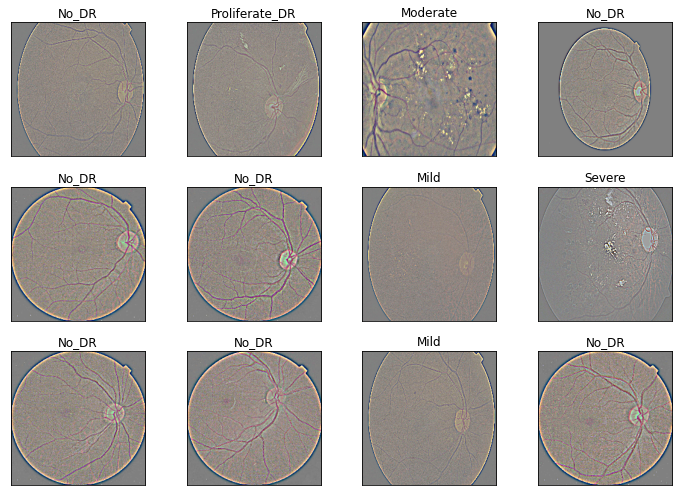

In [ ]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

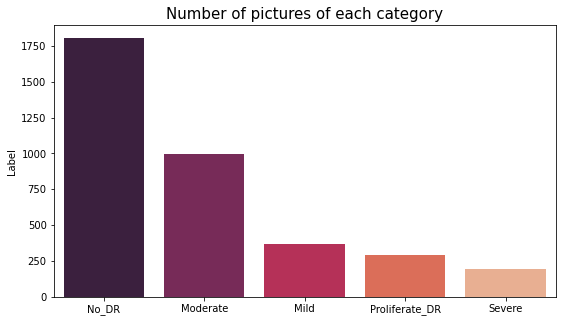

In [ ]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

# 2. Load the Images with a generator<a class="anchor" id="2"></a>

In [ ]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

# 3. Test 27 canned architectures with pre-trained weights<a class="anchor" id="3"></a>

More info about the architectures under: [Module: tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=enhttps://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=en)

In [ ]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [ ]:
# Dictionary with the models
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "EfficientNetB2": {"model":tf.keras.applications.EfficientNetB2, "perf":0},
    "EfficientNetB3": {"model":tf.keras.applications.EfficientNetB3, "perf":0},
    "EfficientNetB4": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB6": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)
    
    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]
    
    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


93/93 [==============================] - 41s 352ms/step - loss: 0.9338 - accuracy: 0.6752 - val_loss: 0.6855 - val_accuracy: 0.7447
DenseNet121          trained in 41.24 sec
93/93 [==============================] - 17s 148ms/step - loss: 0.8958 - accuracy: 0.6664 - val_loss: 0.6757 - val_accuracy: 0.7720
MobileNetV2          trained in 16.75 sec
93/93 [==============================] - 25s 187ms/step - loss: 0.9662 - accuracy: 0.6493 - val_loss: 0.6589 - val_accuracy: 0.7660
DenseNet169          trained in 25.34 sec
93/93 [==============================] - 28s 192ms/step - loss: 0.8860 - accuracy: 0.6901 - val_loss: 0.6658 - val_accuracy: 0.7538
DenseNet201          trained in 27.69 sec
93/93 [==============================] - 20s 164ms/step - loss: 1.3542 - accuracy: 0.4575 - val_loss: 1.2932 - val_accura

In [ ]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, 
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

model  train_accuracy  val_accuracy  Training time (sec)
0         MobileNetV2          0.7242        0.7720                16.75
1         DenseNet169          0.7229        0.7660                25.34
2         ResNet152V2          0.7205        0.7599                25.97
3         InceptionV3          0.7057        0.7538                19.17
4         DenseNet201          0.7326        0.7538                27.69
5        NASNetMobile          0.7040        0.7508                29.25
6           MobileNet          0.7316        0.7508                14.66
7   InceptionResNetV2          0.6949        0.7477                28.43
8         DenseNet121          0.7161        0.7447                41.24
9          ResNet50V2          0.7245        0.7416                17.16
10           Xception          0.7097        0.7386                18.19
11        ResNet101V2          0.7222        0.7204                21.22
12              VGG16          0.6719        0.7112                15.75
13              VGG19          0.6521        0.7021                15.04
14           ResNet50          0.6524        0.6687                17.24
15          ResNet152          0.6372        0.6626                28.66
16          ResNet101          0.6291        0.6353                22.20
17   MobileNetV3Large          0.5509        0.6049                18.08
18   MobileNetV3Small          0.4727        0.4833                17.25
19     EfficientNetB1          0.4784        0.4802                22.41
20     EfficientNetB6          0.4798        0.4802                27.34
21     EfficientNetB0          0.4835        0.4802                20.60
22     EfficientNetB2          0.4710        0.4802                23.08
23     EfficientNetB3          0.4791        0.4802                25.13
24     EfficientNetB4          0.4804        0.4802                27.15
25     EfficientNetB7          0.4788        0.4802                28.17
26     EfficientNetB5          0.4761        0.4802                27.78

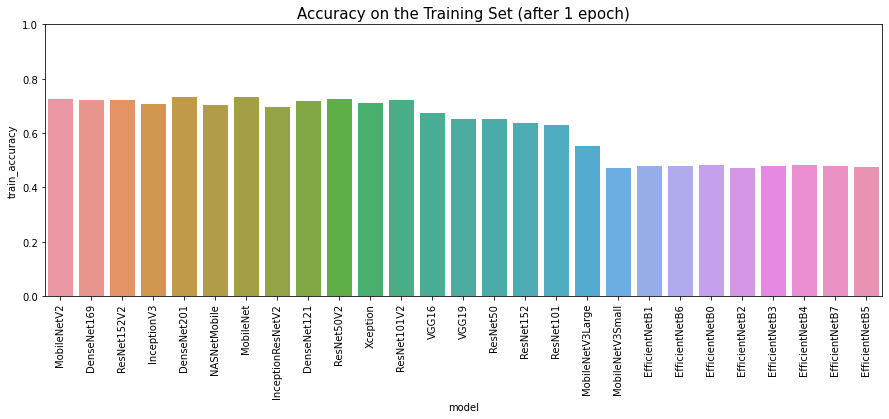

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'train_accuracy', data = df_results)
plt.title('Accuracy on the Training Set (after 1 epoch)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

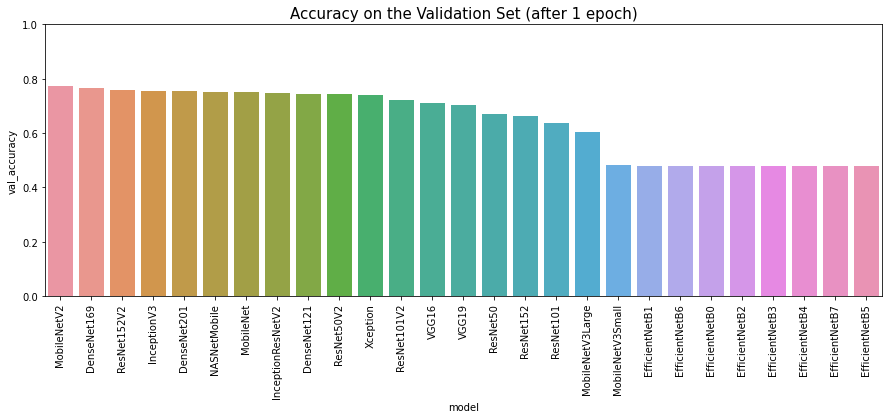

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Accuracy on the Validation Set (after 1 epoch)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

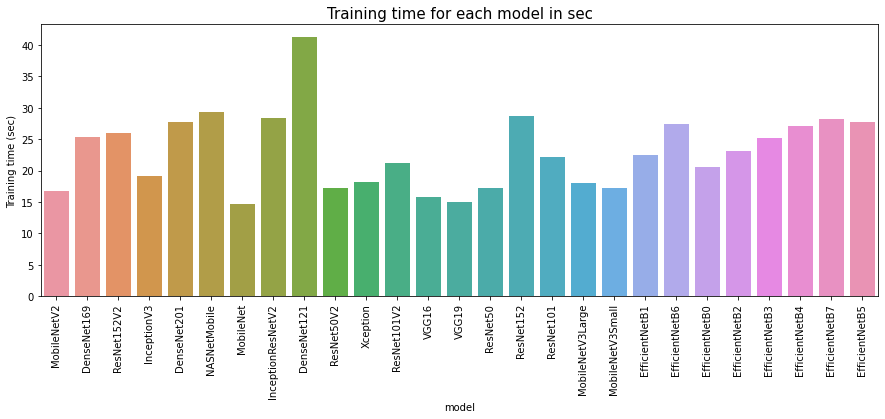

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

# 4. Train the model MobileNetV2<a class="anchor" id="4"></a>

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
93/93 [==============================] - 16s 147ms/step - loss: 0.9928 - accuracy: 0.6458 - val_loss: 0.6678 - val_accuracy: 0.7812
Epoch 2/10
93/93 [==============================] - 13s 139ms/step - loss: 0.6282 - accuracy: 0.7735 - val_loss: 0.6723 - val_accuracy: 0.7325
Epoch 3/10
93/93 [==============================] - 13s 137ms/step - loss: 0.5942 - accuracy: 0.7739 - val_loss: 0.6079 - val_accuracy: 0.7842
Epoch 4/10
93/93 [==============================] - 12s 134ms/step - loss: 0.5335 - accuracy: 0.7987 - val_loss: 0.6323 - val_accuracy: 0.7508
Epoch 5/10
93/93 [==============================] - 13s 139ms/step - loss: 0.5050 - accuracy: 0.8145 - val_loss: 0.6018 - val_accuracy: 0.7386
Epoch 6/10
93/93 [==============================] - 12s 134ms/step - loss: 0.4691 - accuracy: 0.8399 - val_loss: 0.6263 - val_accuracy: 0.7568
Epoch 7/10
93/93 [==============================] - 13s 140ms/step - loss: 0.4636 - accuracy: 0.8270 - val_loss: 0.5756 - val_accuracy: 0.7720

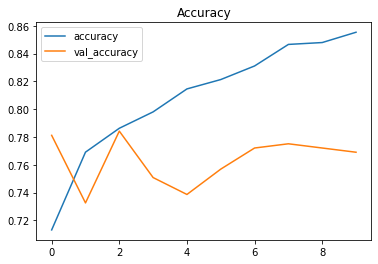

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

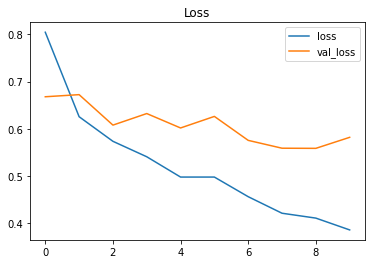

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# 5. Visualize the result<a class="anchor" id="5"></a>

In [ ]:
results = model.evaluate(test_images, verbose=0)

In [ ]:
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 ## Test Loss: 0.67879

## Accuracy on the test set: 74.66%

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Mild', 'Moderate', 'Moderate', 'Moderate', 'Moderate']


In [ ]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

          Mild       0.43      0.28      0.34        32
      Moderate       0.53      0.73      0.62        85
         No_DR       0.94      0.96      0.95       199
Proliferate_DR       0.58      0.26      0.36        27
        Severe       0.33      0.21      0.26        24

      accuracy                           0.75       367
     macro avg       0.56      0.49      0.50       367
  weighted avg       0.74      0.75      0.73       367



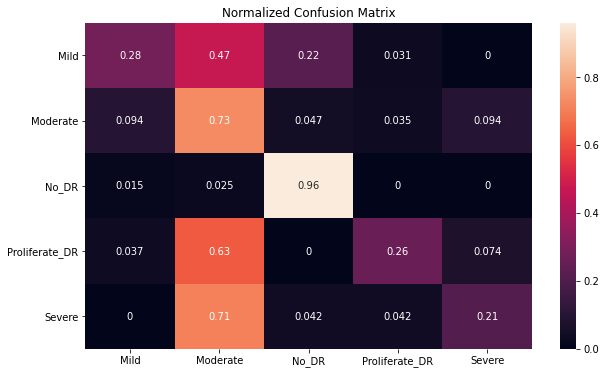

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

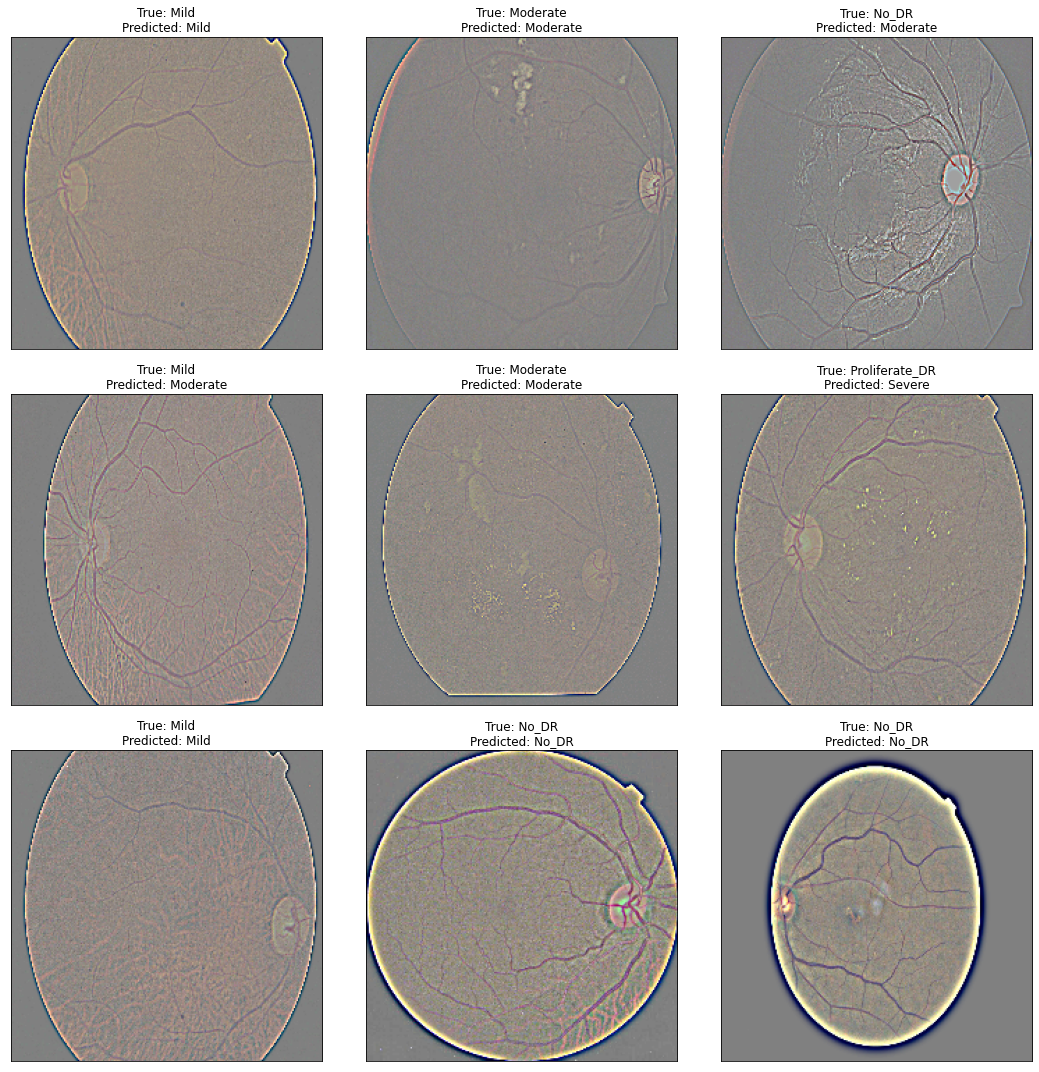

In [ ]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# 6. Class activation heatmap for image classification<a class="anchor" id="6"></a>
## Grad-CAM class activation visualization
*Code adapted from keras.io*

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

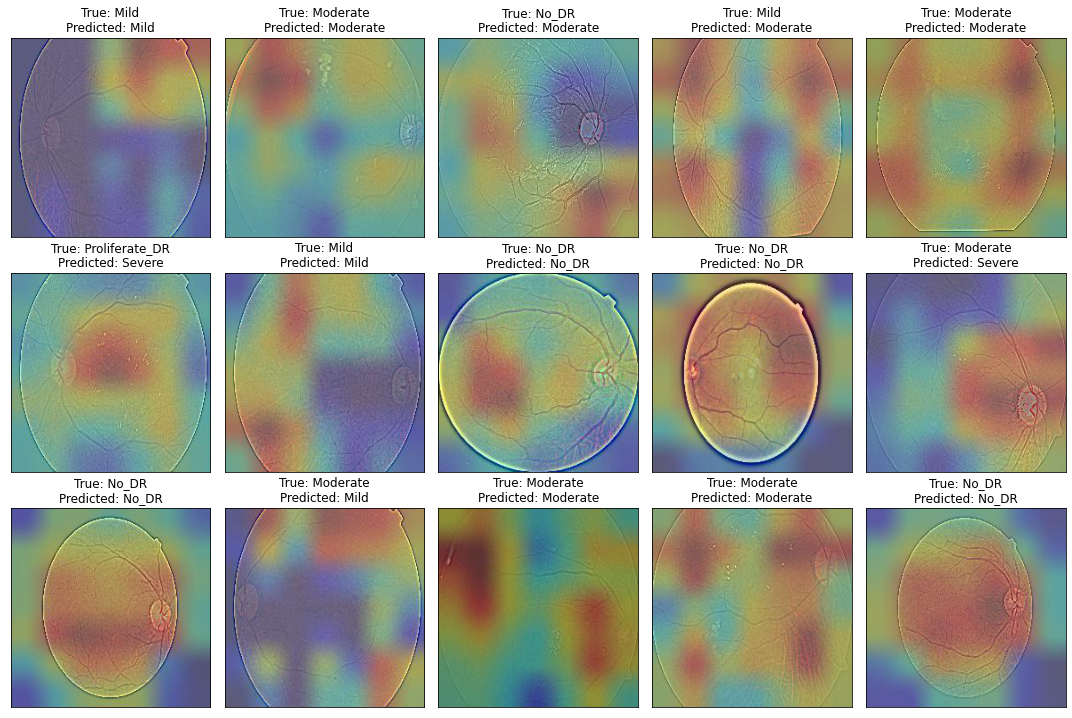

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# 7. Using a two-class model (DR and No_DR)<a class="anchor" id="7"></a>

As we have seen before, the prediction are very accurate to predict if someone has Diabetic Retinopathy or not. Nevertheless, it is not good at predicting the intensity of Diabetic Retinopathy when it is present. Maybe because it is subjective to the doctor to rate the intensity degree and different doctors don't have the same way to evaluate them. Maybe there are other factors taken in consideration to evaluate the intensity, which are independent from the pictures. As this point, without knowing more about the data, we can only speculate.

In this chapter, we'll reduce the label to a two-class model, because we can imagine that the most important part of this analysis is to find out if someone has Diabetic Retinopathy or not.

In [ ]:
# Map the labels to have only "No_DR" and "DR"
image_df_red = image_df.copy()
image_df_red['Label'] = image_df_red['Label'].apply(lambda x: x if x == 'No_DR' else 'DR')
image_df_red.head(5)

Filepath  Label
0  ../input/diabetic-retinopathy-224x224-gaussian...  No_DR
1  ../input/diabetic-retinopathy-224x224-gaussian...     DR
2  ../input/diabetic-retinopathy-224x224-gaussian...     DR
3  ../input/diabetic-retinopathy-224x224-gaussian...  No_DR
4  ../input/diabetic-retinopathy-224x224-gaussian...  No_DR

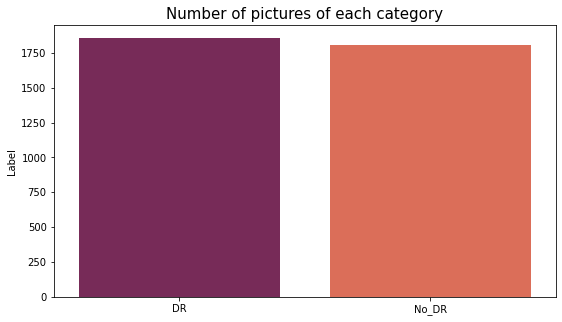

In [ ]:
# Display the number of pictures of each category
vc = image_df_red['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df_red, train_size=0.9, shuffle=True, random_state=1)

In [ ]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()

# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False


inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Found 2966 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.
Found 367 validated image filenames belonging to 2 classes.
Epoch 1/10
93/93 [==============================] - 16s 147ms/step - loss: 0.2805 - accuracy: 0.8908 - val_loss: 0.1788 - val_accuracy: 0.9422
Epoch 2/10
93/93 [==============================] - 12s 134ms/step - loss: 0.1364 - accuracy: 0.9601 - val_loss: 0.1403 - val_accuracy: 0.9422
Epoch 3/10
93/93 [==============================] - 13s 135ms/step - loss: 0.1247 - accuracy: 0.9594 - val_loss: 0.1242 - val_accuracy: 0.9544
Epoch 4/10
93/93 [==============================] - 13s 139ms/step - loss: 0.0996 - accuracy: 0.9652 - val_loss: 0.1329 - val_accuracy: 0.9666
Epoch 5/10
93/93 [==============================] - 12s 133ms/step - loss: 0.0716 - accuracy: 0.9794 - val_loss: 0.1323 - val_accuracy: 0.9544
Epoch 6/10
93/93 [==============================] - 13s 135ms/step - loss: 0.1066 - accuracy: 0.9632 - v

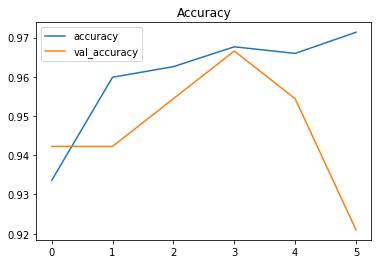

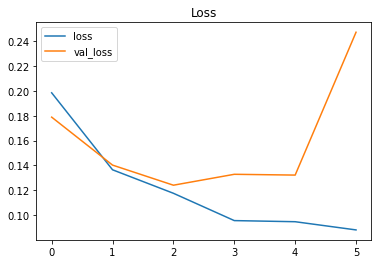

 ## Test Loss: 0.15983

## Accuracy on the test set: 95.37%



The first 5 predictions: ['DR', 'DR', 'No_DR', 'DR', 'DR']
              precision    recall  f1-score   support

          DR       0.96      0.93      0.95       168
       No_DR       0.95      0.97      0.96       199

    accuracy                           0.95       367
   macro avg       0.95      0.95      0.95       367
weighted avg       0.95      0.95      0.95       367



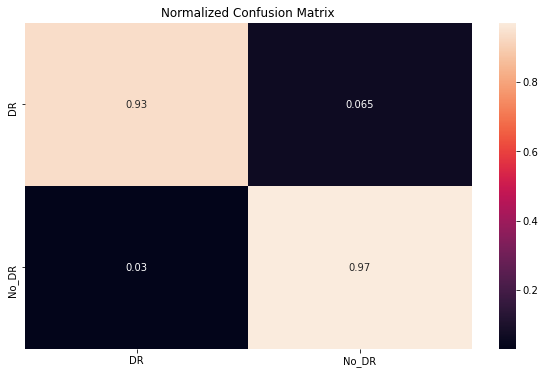

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

results = model.evaluate(test_images, verbose=0)

printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))
print('\n')

# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()